In [4]:
!pip install imbalanced-learn


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
mpl.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [1]:
import pandas as pd
import numpy as np
import mariadb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
from imblearn.over_sampling import SMOTE  # 데이터 불균형 해결

# 📌 1. MariaDB 연결 설정
DB_CONFIG = {
    "user": "root",
    "password": "1234",
    "host": "localhost",
    "database": "finfit"
}

def load_data_from_db():
    """MariaDB에서 데이터를 불러오는 함수"""
    conn = mariadb.connect(**DB_CONFIG)
    query = "SELECT * FROM medical"
    df = pd.read_sql(query, conn)
    conn.close()
    return df.dropna()

# 📌 2. 데이터 불러오기
health_data = load_data_from_db()
print(f"✅ DB에서 데이터 로드 완료! 총 {len(health_data)}개의 데이터\n")

# 📌 3. 사용할 컬럼 정의 (정답 데이터는 X에서 제거!)
columns_to_use = [
    'sex', 'age', 'height', 'weight', 'bmi', 'alchol', 'smoking_history',
    'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
    'fasting_blood_sugar', 'glycated_hemoglobin',
    'sbp_average', 'dbp_average', 'cancer_diagnosis_fathers',
    'cancer_diagnosis_mother', 'cancer_diagnosis_sibling',
    'white_blood_cell_count', 'red_blood_cell_count', 'stress'
]

# 📌 4. 암 위험도 계산 함수
def calculate_cancer_risk(row):
    return (
        (row['cancer_diagnosis_fathers'] * 3) +  
        (row['cancer_diagnosis_mother'] * 3) +  
        (row['cancer_diagnosis_sibling'] * 3) +  
        (row['chol_total'] / 30) +  
        (row['sbp_average'] / 15) +  
        (row['dbp_average'] / 15) +  
        (row['fasting_blood_sugar'] / 15) +  
        (row['glycated_hemoglobin'] * 2.5) +  
        (row['white_blood_cell_count'] * 1.5) +  
        (row['red_blood_cell_count'] * 1.2) +  
        (row['age'] / 20) +  
        (row['bmi'] / 5) +  
        (row['alchol'] * 2) +  
        (row['smoking_history'] * 5) +  
        ((5 - row['stress']) if row['stress'] in [1, 2, 3, 4] else 0) * 2
    )

# 암 위험도 점수 추가
health_data['cancer_risk_score'] = health_data.apply(calculate_cancer_risk, axis=1)

# 📌 5. 정답 데이터(타겟 변수) 정의
disease_labels = {
    '고지혈증': 'dyslipidemia_status',
    '당뇨': 'diabetes',
    '고혈압': 'high_blood_pressure'
}

# 📌 6. 입력 데이터(X)와 정답 데이터(y) 분리
X = health_data[columns_to_use]  # ✅ 정답 데이터 제외
y_disease = health_data[list(disease_labels.values())]  # ✅ 질병 예측용 정답 데이터
y_cancer = health_data["cancer_risk_score"]  # ✅ 암 위험도 예측용 정답 데이터

# 📌 7. 결측값 처리 (비어 있는 데이터가 있어도 학습 가능하도록)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # 평균값으로 결측값 채우기
X_imputed = imputer.fit_transform(X)

# 📌 8. 정규화 (StandardScaler 사용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 📌 9. 데이터 분할 (Train/Test) → `X_test`를 공통으로 사용
X_train, X_test, y_train_disease, y_test_disease, y_train_cancer, y_test_cancer = train_test_split(
    X_scaled, y_disease, y_cancer, test_size=0.2, random_state=42
)

# 📌 10. SMOTE 적용 (데이터 불균형 해결) → 질병 예측에만 적용
# 📌 10. SMOTE 적용 (각 질병별로 개별 적용)
smote = SMOTE(random_state=42)

X_train_smote_dict = {}  # SMOTE 적용된 X_train 저장
y_train_smote_dict = {}  # SMOTE 적용된 y_train 저장

for disease, label in disease_labels.items():
    X_train_smote_dict[disease], y_train_smote_dict[disease] = smote.fit_resample(X_train, y_train_disease[label])


# 📌 11. 질병 예측 모델 학습 (SMOTE 적용된 데이터셋 사용)
optimized_models = {}
best_params = {}
predicted_probs = {}

param_grid = {
    'n_estimators': [200],
    'max_depth': [15],
    'min_samples_split': [5],
    'max_features': ['sqrt']
}

for disease, label in disease_labels.items():
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_smote_dict[disease], y_train_smote_dict[disease])  # ✅ SMOTE 적용된 데이터 사용
    best_params[disease] = grid_search.best_params_

    model = RandomForestClassifier(**best_params[disease], random_state=42)
    model.fit(X_train_smote_dict[disease], y_train_smote_dict[disease])  # ✅ SMOTE 적용된 데이터 사용
    predicted_probs[disease] = model.predict_proba(X_test)[:, 1]
    optimized_models[disease] = model


# 📌 12. 암 위험도 예측 모델 학습 (RandomForestRegressor 사용)
cancer_model = RandomForestRegressor(n_estimators=200, random_state=42)
cancer_model.fit(X_train, y_train_cancer)
predicted_probs["암"] = cancer_model.predict(X_test)

# 📌 13. 암 위험도 점수 백분위 변환
health_data["cancer_risk_percentile"] = health_data["cancer_risk_score"].rank(pct=True, ascending=True) * 100
cancer_risk_percentile = health_data.loc[y_test_cancer.index, "cancer_risk_percentile"].values

# 📌 14. 위험도 분류 함수 추가
def classify_general_risk(prob):
    """일반적인 유병 확률을 저위험/중위험/고위험으로 변환"""
    if prob < 0.10:
        return "저위험"
    elif prob < 0.30:
        return "중위험"
    else:
        return "고위험"

def classify_cancer_risk(percentile):
    """암 위험도 순위를 바탕으로 위험도 분류"""
    if percentile <= 10:
        return "고위험"
    elif percentile <= 30:
        return "중위험"
    else:
        return "저위험"

# 📌 15. 최종 결과 정리 (위험도 추가!)
risk_data = pd.DataFrame({
    "고지혈증 유병 확률": predicted_probs["고지혈증"],
    "당뇨 유병 확률": predicted_probs["당뇨"],
    "고혈압 유병 확률": predicted_probs["고혈압"],
    "암 위험도 점수": predicted_probs["암"],
    "암 위험도": [classify_cancer_risk(x) for x in cancer_risk_percentile],
    "암 위험도 순위": [f"상위 {int(x)}%" for x in cancer_risk_percentile],  # ✅ 백분위 변환
})

# 📌 **위험도(저위험/중위험/고위험) 정보 추가**
for disease in ["고지혈증", "당뇨", "고혈압"]:
    risk_data[f"{disease} 위험도"] = risk_data[f"{disease} 유병 확률"].apply(classify_general_risk)  # ✅ 위험도 추가!

# 📌 확률 값을 %로 변환하는 함수
def format_percentage(value):
    return f"{value * 100:.1f}%"  # 예: 0.231 → 23.1%

# 📌 고지혈증, 당뇨, 고혈압 유병 확률을 %로 변환
for disease in ["고지혈증", "당뇨", "고혈압"]:
    risk_data[f"{disease} 유병 확률"] = risk_data[f"{disease} 유병 확률"].apply(format_percentage)

# ✅ 최종 결과 출력
print("\n📊 유병 확률 및 위험도 분석 결과")
display(risk_data.head(30))


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\4294391921.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ DB에서 데이터 로드 완료! 총 4599개의 데이터



c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1540, in _execut


📊 유병 확률 및 위험도 분석 결과


,고지혈증 유병 확률,당뇨 유병 확률,고혈압 유병 확률,암 위험도 점수,암 위험도,암 위험도 순위,고지혈증 위험도,당뇨 위험도,고혈압 위험도
0,3.3%,1.1%,0.0%,79.391456,중위험,상위 10%,저위험,저위험,저위험
1,0.8%,0.0%,0.0%,82.728019,저위험,상위 41%,저위험,저위험,저위험
2,100.0%,0.0%,2.2%,84.205006,저위험,상위 45%,고위험,저위험,저위험
3,1.0%,0.6%,0.1%,80.784810,중위험,상위 27%,저위험,저위험,저위험
4,1.6%,0.2%,37.4%,80.115728,중위험,상위 21%,저위험,저위험,고위험
5,1.7%,0.1%,0.4%,81.777442,중위험,상위 28%,저위험,저위험,저위험
6,4.5%,0.8%,0.0%,78.222898,저위험,상위 32%,저위험,저위험,저위험
7,2.2%,0.0%,0.9%,82.219246,저위험,상위 42%,저위험,저위험,저위험
8,1.1%,6.0%,1.2%,84.950124,저위험,상위 53%,저위험,저위험,저위험
9,93.3%,1.2%,3.6%,88.839683,저위험,상위 76%,고위험,저위험,저위험


In [2]:
import pickle
import os

# ✅ 모델 저장 경로 설정
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)  # models 폴더 없으면 생성

# ✅ 모델 저장 (customer_features 제거)
model_path = os.path.join(model_dir, "disease_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "optimized_models": optimized_models,
        "cancer_model": cancer_model,
        "scaler": scaler,
        "imputer": imputer
    }, f)

print(f"✅ 모델 저장 완료: {model_path}")


✅ 모델 저장 완료: models\disease_model.pkl


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


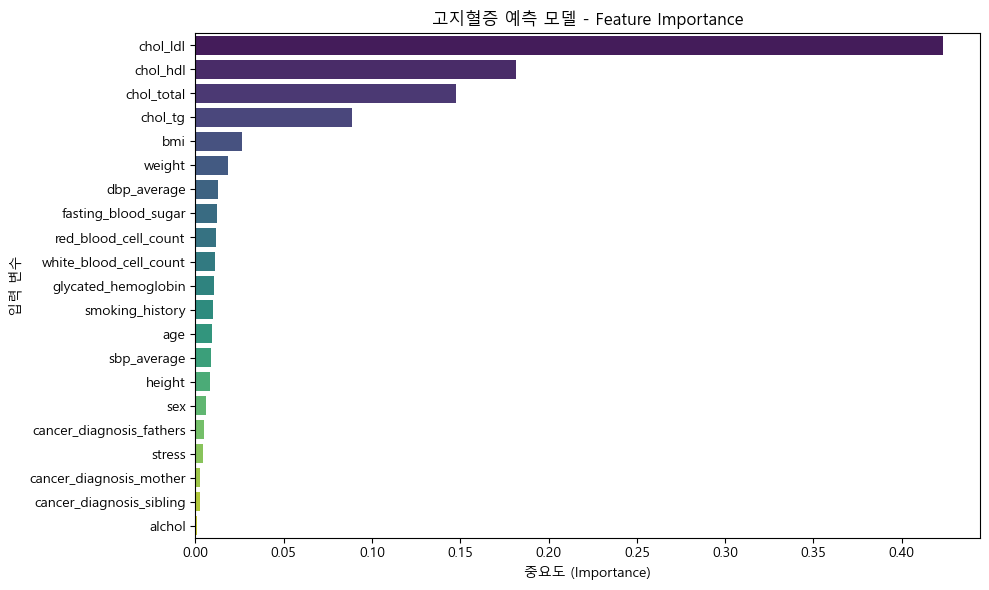

C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


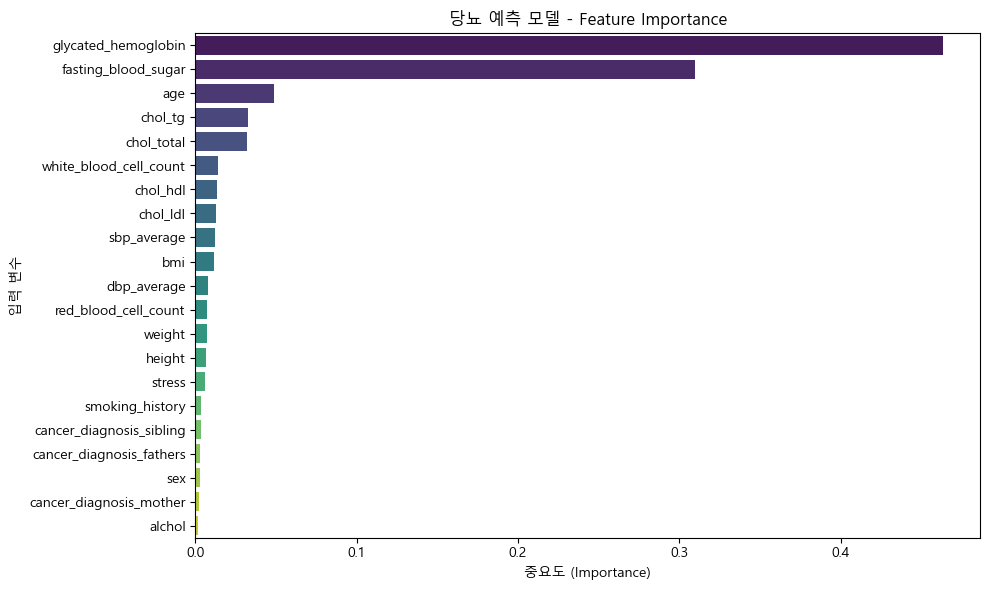

C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


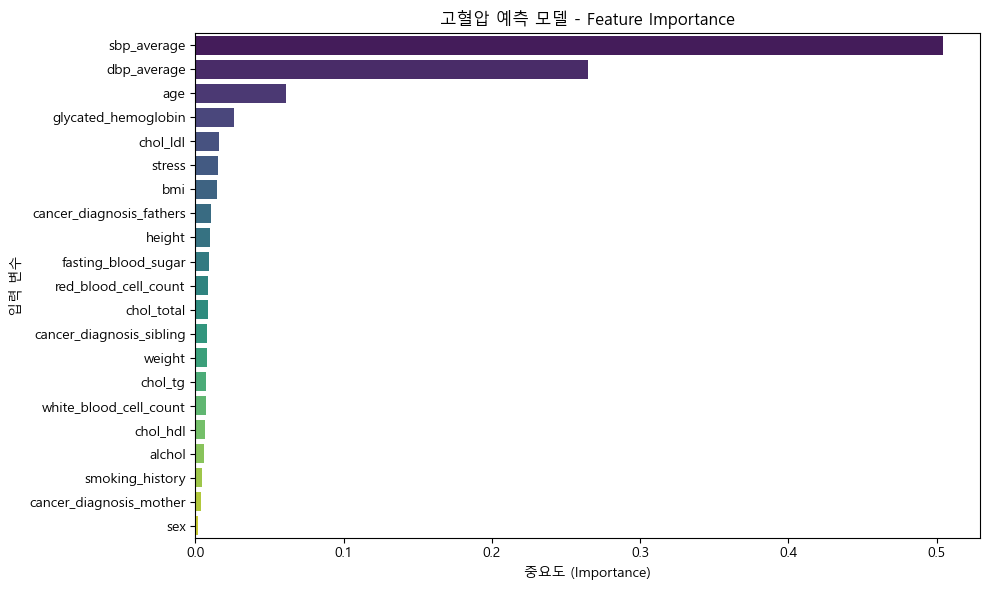

In [4]:
# 📌 각 질병에 대한 Feature Importance 시각화
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")
    plt.title(f"{title} - Feature Importance")
    plt.xlabel("중요도 (Importance)")
    plt.ylabel("입력 변수")
    plt.tight_layout()
    plt.show()

# 📌 각 질병 모델의 feature importance 시각화
for disease, model in optimized_models.items():
    plot_feature_importance(model, columns_to_use, f"{disease} 예측 모델")


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


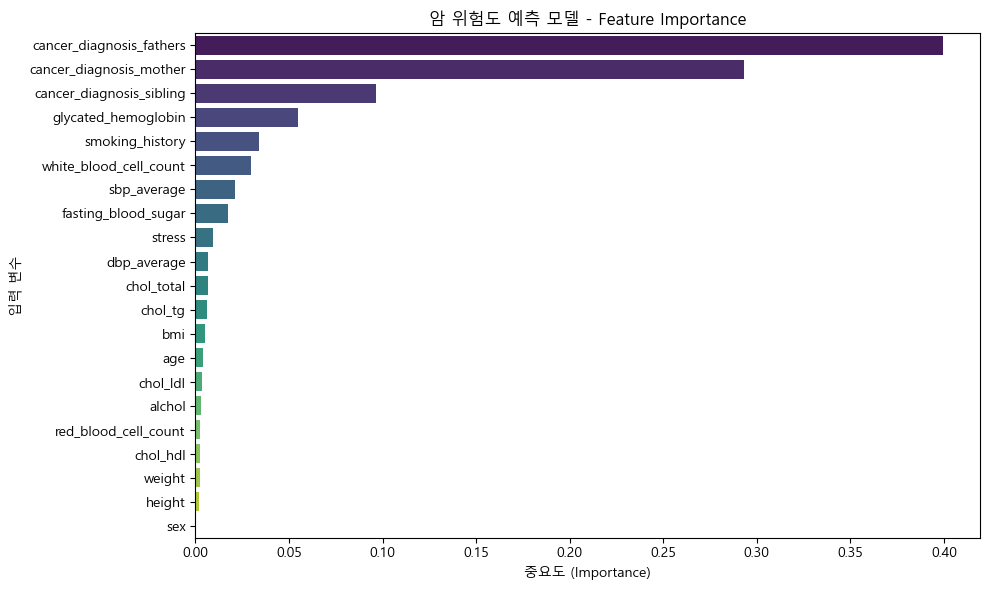

In [5]:
plot_feature_importance(cancer_model, columns_to_use, "암 위험도 예측 모델")


C:\Users\arsey\AppData\Local\Temp\ipykernel_18188\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


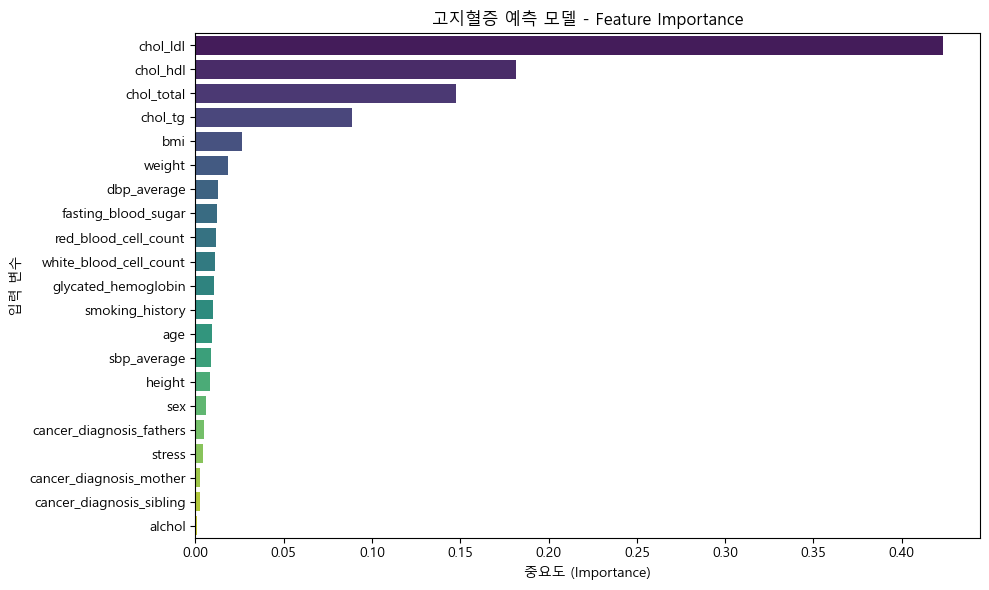

In [7]:
# 고지혈증 예측 모델 Feature Importance 보기
plot_feature_importance(optimized_models["고지혈증"], columns_to_use, "고지혈증 예측 모델")


In [5]:
import mariadb
import pandas as pd

# DB 연결 정보
DB_CONFIG = {
    "user": "root",
    "password": "1234",
    "host": "localhost",
    "database": "finfit"
}

# 데이터 불러오는 함수
def load_data_from_db():
    conn = mariadb.connect(**DB_CONFIG)
    query = "SELECT * FROM medical"
    df = pd.read_sql(query, conn)
    conn.close()
    return df.dropna()

# ✅ health_data 변수 생성
health_data = load_data_from_db()
print(f"✅ DB에서 데이터 로드 완료! 총 {len(health_data)}개의 데이터")

C:\Users\arsey\AppData\Local\Temp\ipykernel_53332\3909213573.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ DB에서 데이터 로드 완료! 총 4599개의 데이터


In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 질병 라벨 정의
disease_labels = {
    '고지혈증': 'dyslipidemia_status',
    '당뇨': 'diabetes',
    '고혈압': 'high_blood_pressure'
}

# 사용할 피처
columns_to_use = [
    'sex', 'age', 'height', 'weight', 'bmi', 'alchol', 'smoking_history',
    'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
    'fasting_blood_sugar', 'glycated_hemoglobin',
    'sbp_average', 'dbp_average', 'cancer_diagnosis_fathers',
    'cancer_diagnosis_mother', 'cancer_diagnosis_sibling',
    'white_blood_cell_count', 'red_blood_cell_count', 'stress'
]

# X, y 분리
X = health_data[columns_to_use]
y_disease = health_data[list(disease_labels.values())]

# 결측값 처리 + 스케일링
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 데이터 분할
X_train, X_test, y_train_disease, y_test_disease = train_test_split(
    X_scaled, y_disease, test_size=0.2, random_state=42
)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote_dict = {}
y_train_smote_dict = {}

for disease, label in disease_labels.items():
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train_disease[label])
    X_train_smote_dict[disease] = X_resampled
    y_train_smote_dict[disease] = y_resampled


c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1540, in _execut

c:\venvs\finfit\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1127, number of negative: 1127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2254, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\venvs\finfit\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2667964237.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_list, y=list(models.keys()), palette='Blues_r')
C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2667964237.py:75: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\venvs\finfit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


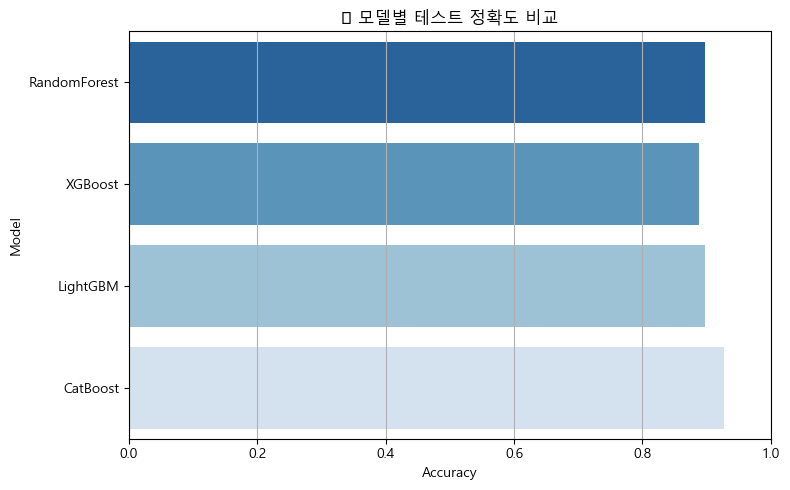

ModuleNotFoundError: No module named 'ace_tools'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

import seaborn as sns
import numpy as np

# 샘플 데이터 생성 (대체용)
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, 
                           n_classes=2, weights=[0.7, 0.3], random_state=42)

columns_to_use = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns_to_use)
df['target'] = y

# 결측값 처리 + 정규화
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(df.drop('target', axis=1))
X_scaled = scaler.fit_transform(X_imputed)
y = df['target'].values

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 모델 정의 (간단한 하이퍼파라미터로 빠르게 돌리기)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=50, depth=10, learning_rate=0.1, verbose=0, random_state=42)
}

# 결과 저장용
accuracy_list = []
feature_df_list = []

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracy_list.append(acc)

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_df = pd.DataFrame({
            'Feature': columns_to_use,
            'Importance': importance,
            'Model': name
        }).sort_values(by='Importance', ascending=False).head(5)
        feature_df_list.append(feature_df)

# 정확도 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_list, y=list(models.keys()), palette='Blues_r')
plt.title("🧠 모델별 테스트 정확도 비교")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Feature Importance 시각화
import ace_tools as tools; tools.display_dataframe_to_user(name="모델별 상위 중요 피처", dataframe=pd.concat(feature_df_list))


In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd

# 데이터 생성
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10,
                           n_classes=2, weights=[0.7, 0.3], random_state=42)
columns_to_use = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns_to_use)

# 전처리
imputer = SimpleImputer()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(imputer.fit_transform(df))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=10, learning_rate=0.1),
    "CatBoost": CatBoostClassifier(iterations=50, depth=10, learning_rate=0.1, verbose=0)
}

accuracy_list = []
feature_df_list = []

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    pred = model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, pred))
    
    if hasattr(model, 'feature_importances_'):
        feature_df = pd.DataFrame({
            'Model': name,
            'Feature': columns_to_use,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(5)
        feature_df_list.append(feature_df)


c:\venvs\finfit\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1127, number of negative: 1127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2254, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\venvs\finfit\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\arsey\AppData\Local\Temp\ipykernel_53332\2119757337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_list, y=list(models.keys()), palette='coolwarm')


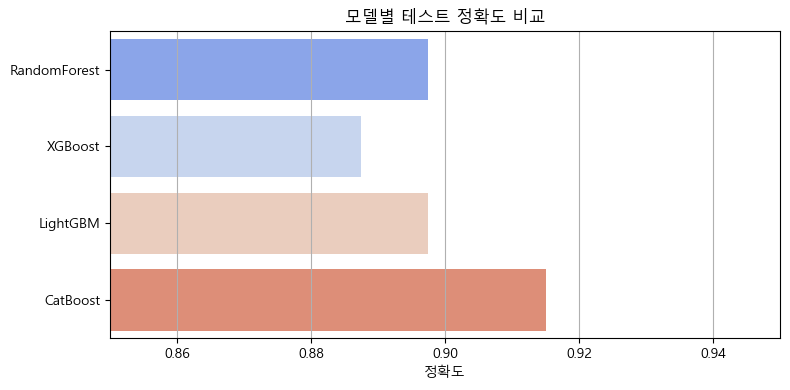

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=accuracy_list, y=list(models.keys()), palette='coolwarm')
plt.title("모델별 테스트 정확도 비교")
plt.xlabel("정확도")
plt.xlim(0.85, 0.95)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [16]:
comparison_table = pd.DataFrame({
    "모델명": ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
    "정확도(Accuracy)": accuracy_list,
    "해석 용이성": ["높음", "중간", "중간", "낮음"],
    "학습 속도": ["빠름", "중간", "빠름", "느림"],
    "소수 클래스 대응력": ["낮음", "중간", "보통", "우수"],
    "장점": [
        "해석 쉬움, 튜닝 없이도 안정적인 성능",
        "성능 우수, 복잡한 패턴 학습 가능",
        "빠른 학습 속도, 효율적 자원 사용",
        "소수 클래스에 강함, 높은 예측력"
    ],
    "단점": [
        "복잡한 패턴에서 성능 한계",
        "튜닝 필요, 학습 속도 느릴 수 있음",
        "다소 민감함, 과적합 가능성",
        "학습 시간 길고 해석 어려움"
    ]
})
comparison_table


,모델명,정확도(Accuracy),해석 용이성,학습 속도,소수 클래스 대응력,장점,단점
0,RandomForest,0.8975,높음,빠름,낮음,"해석 쉬움, 튜닝 없이도 안정적인 성능",복잡한 패턴에서 성능 한계
1,XGBoost,0.8875,중간,중간,중간,"성능 우수, 복잡한 패턴 학습 가능","튜닝 필요, 학습 속도 느릴 수 있음"
2,LightGBM,0.8975,중간,빠름,보통,"빠른 학습 속도, 효율적 자원 사용","다소 민감함, 과적합 가능성"
3,CatBoost,0.9150,낮음,느림,우수,"소수 클래스에 강함, 높은 예측력",학습 시간 길고 해석 어려움
